# Clustering Zillow Project Final Notebook

### Randy French

### 9-28-2021

## Project Description:
What is driving the errors in the Zestimates?

For this project, I will continue working with the Zillow dataset, focusing on single unit / single-family homes, using the 2017 properties and predictions data.

This notebook will be a continuation of my regression modeling. I am adding clustering methodologies to see what kind of improvements we can make.

## Project Goals:
- Use clustering methodologies to identify drivers of logerror in Zillow Zestimates
- Create modules storing functions of each step of the data pipeline
- Thoroughly document each step
- Construct at least 4 models
- Make sure project is reproduceable

## Project Deliverables:
- Final Report Notebook detailing all of my findings and methodologies. -
- Sections indicated with markdown headings in my final notebook with a good title and the documentation is sufficiently explanatory and of high quality
- A Python module or modules that automate the data acquisistion and preperation process, imported and used in final notebook
- README file that details the project specs, planning, key findings, and steps to reproduce

## Project Planning:
- Write a SQL query, and put in a function to acquire data from the Zillow dataset on Codeup database, acquire.py
- Create a wrangle.py module complete with all necessary functions to clean the data
- Use visualizations and statistical testing to explore relationships between variables and logerror
- Use key variables to create clusters, and perform statistical testing on clusters to see if they are useful
- Establish a baseline model, and compute its RMSE
- Use key variables and clusters to create 4 models, with the aim of outperforming the baseline
- Use best model on test data
- Draw conclusions at each step of the pipeline
- Include next steps / if I had more time...


### Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import env
import wrangle_zillow as wz
import os
import acquire

from sklearn.model_selection import learning_curve

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score


## Acquire

In [2]:
df = acquire.get_zillow_data()

In [3]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [4]:
#77381 rows, 68 columns and 2,555,514 missing values in the entire dataframe
wz.summarize(df)

There are total of 2555514 missing values in the entire dataframe.

-------------------


Dataframe head: 
|    |      id |   parcelid |   airconditioningtypeid |   architecturalstyletypeid |   basementsqft |   bathroomcnt |   bedroomcnt |   buildingclasstypeid |   buildingqualitytypeid |   calculatedbathnbr |   decktypeid |   finishedfloor1squarefeet |   calculatedfinishedsquarefeet |   finishedsquarefeet12 |   finishedsquarefeet13 |   finishedsquarefeet15 |   finishedsquarefeet50 |   finishedsquarefeet6 |   fips |   fireplacecnt |   fullbathcnt |   garagecarcnt |   garagetotalsqft |   hashottuborspa |   heatingorsystemtypeid |    latitude |    longitude |   lotsizesquarefeet |   poolcnt |   poolsizesum |   pooltypeid10 |   pooltypeid2 |   pooltypeid7 |   propertycountylandusecode |   propertylandusetypeid |   propertyzoningdesc |   rawcensustractandblock |   regionidcity |   regionidcounty |   regionidneighborhood |   regionidzip |   roomcnt |   storytypeid |   threequarterbathnbr | 

(-2632.9260000000004, 298541.5]    7739
(298541.5, 596734.0]               7682
(596734.0, 894926.5]               7585
(894926.5, 1193119.0]              7694
(1193119.0, 1491311.5]             7827
(1491311.5, 1789504.0]             7813
(1789504.0, 2087696.5]             7794
(2087696.5, 2385889.0]             7698
(2385889.0, 2684081.5]             7710
(2684081.5, 2982274.0]             7839
Name: id, dtype: int64
(10554877.537, 26409601.2]    77350
(26409601.2, 42107347.4]          0
(42107347.4, 57805093.6]          0
(57805093.6, 73502839.8]          0
(73502839.8, 89200586.0]          1
(89200586.0, 104898332.2]         1
(104898332.2, 120596078.4]        0
(120596078.4, 136293824.6]        0
(136293824.6, 151991570.8]        0
(151991570.8, 167689317.0]       29
Name: parcelid, dtype: int64
(0.987, 2.2]    23133
(2.2, 3.4]          0
(3.4, 4.6]          0
(4.6, 5.8]        167
(5.8, 7.0]          0
(7.0, 8.2]          0
(8.2, 9.4]         26
(9.4, 10.6]         0
(10.6, 11.8]

(3097.9339999999997, 42797.5]    55659
(42797.5, 82104.0]               18118
(82104.0, 121410.5]               1053
(121410.5, 160717.0]                 0
(160717.0, 200023.5]                 0
(200023.5, 239330.0]                 0
(239330.0, 278636.5]                24
(278636.5, 317943.0]                 0
(317943.0, 357249.5]                 0
(357249.5, 396556.0]              1056
Name: regionidcity, dtype: int64
(1284.184, 1467.5]    20593
(1467.5, 1649.0]          0
(1649.0, 1830.5]          0
(1830.5, 2012.0]          0
(2012.0, 2193.5]       6237
(2193.5, 2375.0]          0
(2375.0, 2556.5]          0
(2556.5, 2738.0]          0
(2738.0, 2919.5]          0
(2919.5, 3101.0]      50551
Name: regionidcounty, dtype: int64
(6194.784, 82673.5]     11546
(82673.5, 158395.0]      4585
(158395.0, 234116.5]       43
(234116.5, 309838.0]    11551
(309838.0, 385559.5]       77
(385559.5, 461281.0]     1948
(461281.0, 537002.5]        0
(537002.5, 612724.0]        0
(612724.0, 688445.5]  

   num_cols_missing percent_cols_missing  index
0                23    33.82352941176471      2
1                24   35.294117647058826     13
2                25    36.76470588235294     24
3                26    38.23529411764706     65
4                27   39.705882352941174    316
5                28    41.17647058823529    455
6                29    42.64705882352941   5270
7                30    44.11764705882353   3455
8                31   45.588235294117645   9891
9                32    47.05882352941176  12579
10               33   48.529411764705884  14782
11               34                 50.0  13327
12               35   51.470588235294116   5148
13               36    52.94117647058824   5775
14               37    54.41176470588235   3620
15               38    55.88235294117647   1925
16               39    57.35294117647059    285
17               40    58.82352941176471    230
18               41    60.29411764705882     29
19               42    61.76470588235294

### Takeaways from Acquire:
- Target variable: 'logerror'
- This dataframe has 77,381 rows and 68 columns
- A fairly large dataset with over 2.5 million missing values that will either need to be dropped or imputed
- There are 11 columns that have the dtype as 'object' that will either need to be dropped or converted to int
- Create a column with county names

- Dataset is pulling from the 2017 properties and predictions tables, will need some tidding up
- Will explore further to see what I have to work with

**************************************************************

### Data Preperation To Do:
- Encode or drop object columns
- Create a column named county
- Drop columns that have more than 50% null values
- Drop rows that have more than 75% null values
- Other columns to drop:
    - parcelid', 'calculatedbathnbr','finishedsquarefeet12','fullbathcnt','heatingorsystemtypeid','propertycountylandusecode',
'propertylandusetypeid', 'propertyzoningdesc','censustractandblock','propertylandusedesc'
- replace nulls in unitcnt with 1




## Data Preparation

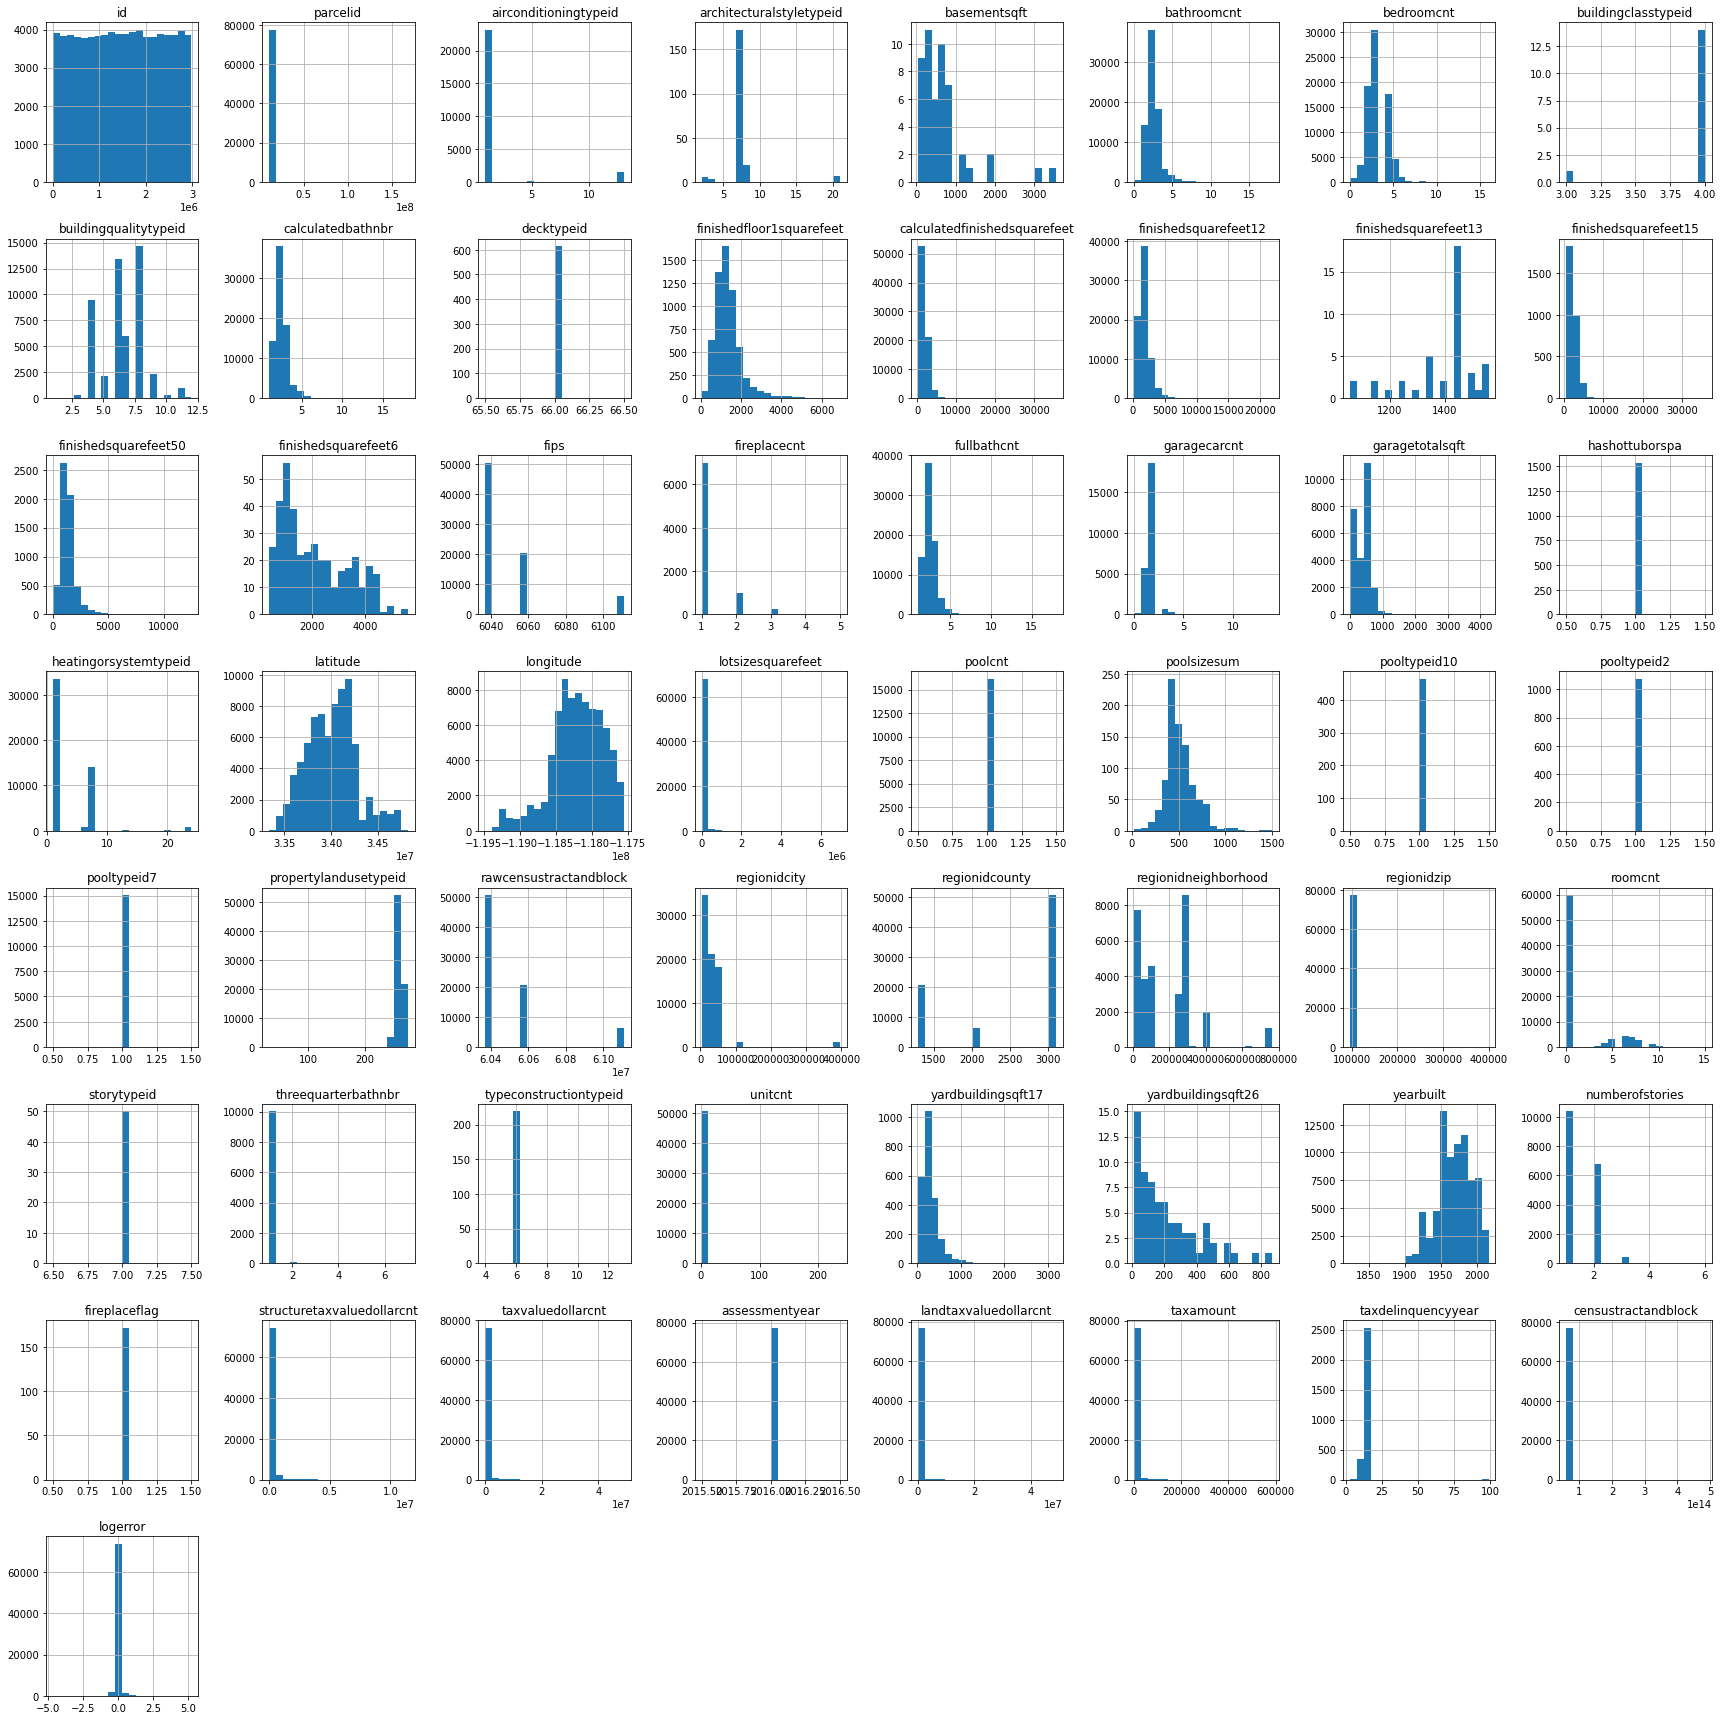

In [5]:
#visualize distributions 
#check for outliers
# visualize my numerical data types

df.hist(figsize=(24,24), bins=20)
plt.tight_layout()
plt.show()

### Take a look at some columns that should have value in our models 

In [7]:
def outlier_bound_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')

In [10]:
outlier_bound_calculation(df, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


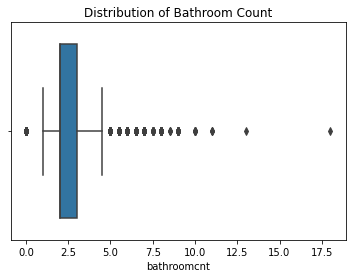

In [12]:
#visualize the same data as above
sns.boxplot(df.bathroomcnt)
plt.title('Distribution of Bathroom Count')
plt.show()

In [13]:
outlier_bound_calculation(df, 'bedroomcnt')

For bedroomcnt the lower bound is -1.0 and  upper bound is 7.0


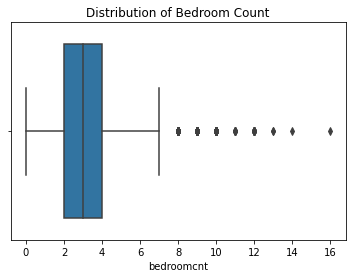

In [14]:
#visualize the same data as above
sns.boxplot(df.bedroomcnt)
plt.title('Distribution of Bedroom Count')
plt.show()

In [15]:
outlier_bound_calculation(df, 'calculatedfinishedsquarefeet')

For calculatedfinishedsquarefeet the lower bound is nan and  upper bound is nan


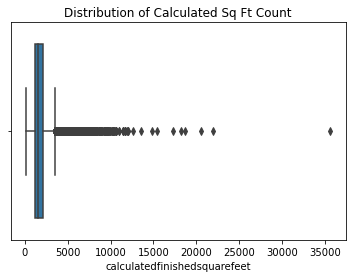

In [17]:
#visualize the same data as above
sns.boxplot(df.calculatedfinishedsquarefeet)
plt.title('Distribution of Calculated Sq Ft Count')
plt.show()

### R

In [18]:
df = wz.wrangle_zillow()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69523 entries, 0 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   69523 non-null  float64
 1   bedroomcnt                    69523 non-null  float64
 2   buildingqualitytypeid         69523 non-null  float64
 3   calculatedfinishedsquarefeet  69523 non-null  float64
 4   fips                          69523 non-null  float64
 5   latitude                      69523 non-null  float64
 6   longitude                     69523 non-null  float64
 7   lotsizesquarefeet             69523 non-null  float64
 8   rawcensustractandblock        69523 non-null  float64
 9   regionidcity                  69523 non-null  float64
 10  regionidcounty                69523 non-null  float64
 11  regionidzip                   69523 non-null  float64
 12  roomcnt                       69523 non-null  float64
 13  u

### P

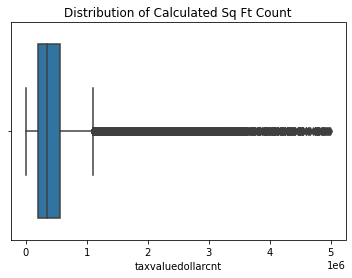

In [22]:
#visualize the same data as above
sns.boxplot(df.taxvaluedollarcnt)
plt.title('Distribution of Calculated Sq Ft Count')
plt.show()

In [21]:
df.describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
count,69523.000000,69523.000000,69523.000000,69523.000000,69523.000000,6.952300e+04,6.952300e+04,6.952300e+04,6.952300e+04,69523.000000,...,69523.000000,69523.000000,69523.0,69523.000000,6.952300e+04,6.952300e+04,69523.0,6.952300e+04,69523.000000,69523.000000
mean,2.251535,3.007595,6.355695,1728.652921,6049.326539,3.400259e+07,-1.181934e+08,2.760971e+04,6.049624e+07,33480.648332,...,96612.149950,1.588280,1.0,1969.019562,1.799322e+05,4.649566e+05,2016.0,2.850243e+05,5671.669381,0.016507
std,0.907034,0.992840,1.361063,852.481801,20.842299,2.681706e+05,3.609820e+05,1.191192e+05,2.068667e+05,46511.773927,...,4003.511602,2.905171,0.0,22.973787,1.756762e+05,4.549193e+05,0.0,3.273026e+05,5273.568547,0.165696
min,1.000000,1.000000,1.000000,360.000000,6037.000000,3.333953e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,...,95982.000000,0.000000,1.0,1878.000000,4.400000e+01,3.254000e+03,2016.0,1.610000e+02,19.920000,-4.655420
25%,2.000000,2.000000,6.000000,1164.000000,6037.000000,3.380385e+07,-1.184091e+08,6.000000e+03,6.037312e+07,12447.000000,...,96206.000000,0.000000,1.0,1954.000000,8.294650e+04,2.028430e+05,2016.0,8.237100e+04,2667.140000,-0.023775
50%,2.000000,3.000000,6.000000,1507.000000,6037.000000,3.401276e+07,-1.181630e+08,7.313000e+03,6.037621e+07,25218.000000,...,96411.000000,0.000000,1.0,1970.000000,1.337000e+05,3.544900e+05,2016.0,2.030500e+05,4374.600000,0.006513
75%,3.000000,4.000000,7.000000,2047.000000,6059.000000,3.417455e+07,-1.179133e+08,1.063650e+04,6.059052e+07,45457.000000,...,96990.000000,0.000000,1.0,1986.000000,2.131015e+05,5.620000e+05,2016.0,3.659580e+05,6768.600000,0.038071
max,10.000000,11.000000,12.000000,7970.000000,6111.000000,3.481877e+07,-1.175723e+08,6.971010e+06,6.111009e+07,396556.000000,...,399675.000000,14.000000,1.0,2016.000000,3.097672e+06,4.993132e+06,2016.0,4.847224e+06,61992.630000,3.394544


In [25]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [30]:
df = remove_outliers(df, 1.5, ['bedroomcnt', 'bathroomcnt', 'taxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt'])
df

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county
1,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,None,Ventura
2,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,None,Orange
3,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,Los Angeles
5,2.0,3.0,6.0,1492.0,6111.0,34230044.0,-118993991.0,903.0,6.111005e+07,51239.0,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,-0.020526,2017-01-01,None,Ventura
7,1.0,2.0,5.0,738.0,6037.0,34149214.0,-118239357.0,4214.0,6.037302e+07,45457.0,...,1922.0,18890.0,218552.0,2016.0,199662.0,2366.08,0.101723,2017-01-01,None,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77374,2.0,4.0,6.0,1633.0,6037.0,33870815.0,-118070858.0,4630.0,6.037555e+07,30267.0,...,1962.0,125466.0,346534.0,2016.0,221068.0,4175.08,0.001082,2017-09-19,Central,Los Angeles
77377,2.0,4.0,6.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,6.111008e+07,27110.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,0.013209,2017-09-21,None,Ventura
77378,1.0,3.0,4.0,1032.0,6037.0,34040895.0,-118038169.0,5074.0,6.037434e+07,36502.0,...,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,0.037129,2017-09-21,Central,Los Angeles
77379,2.0,3.0,6.0,1762.0,6037.0,33937685.0,-117996709.0,6347.0,6.037503e+07,14634.0,...,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,0.007204,2017-09-25,Central,Los Angeles


In [31]:
df.describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
count,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,5.028500e+04,5.028500e+04,50285.000000,5.028500e+04,50285.000000,...,50285.000000,50285.000000,50285.0,50285.000000,50285.000000,5.028500e+04,50285.0,50285.000000,50285.000000,50285.000000
mean,2.040012,2.982917,6.024699,1551.371025,6051.136224,3.398773e+07,-1.181674e+08,6912.822432,6.051415e+07,34316.878095,...,96617.916039,1.876186,1.0,1965.376812,128486.432714,3.442792e+05,2016.0,215792.787988,4255.987853,0.015394
std,0.691372,0.885906,1.188061,555.293592,21.610394,2.739938e+05,3.706052e+05,2428.049377,2.145060e+05,49268.509418,...,1957.005968,3.000633,0.0,22.522104,72812.255677,2.068690e+05,0.0,167811.059686,2360.805504,0.161172
min,1.000000,1.000000,1.000000,360.000000,6037.000000,3.333953e+07,-1.194753e+08,435.000000,6.037101e+07,3491.000000,...,95982.000000,0.000000,1.0,1878.000000,44.000000,3.254000e+03,2016.0,1627.000000,19.920000,-4.655420
25%,2.000000,2.000000,6.000000,1153.000000,6037.000000,3.378834e+07,-1.183667e+08,5625.000000,6.037405e+07,12447.000000,...,96218.000000,0.000000,1.0,1952.000000,72225.000000,1.803450e+05,2016.0,70690.000000,2429.280000,-0.023687
50%,2.000000,3.000000,6.000000,1451.000000,6037.000000,3.396351e+07,-1.181166e+08,7000.000000,6.037800e+07,25218.000000,...,96475.000000,0.000000,1.0,1964.000000,115159.000000,3.223880e+05,2016.0,185001.000000,3988.850000,0.005543
75%,2.500000,4.000000,6.000000,1854.000000,6059.000000,3.417473e+07,-1.178962e+08,7560.000000,6.059063e+07,42967.000000,...,97004.000000,5.000000,1.0,1982.000000,173161.000000,4.730000e+05,2016.0,317908.000000,5739.220000,0.035350
max,4.000000,6.000000,11.000000,5612.000000,6111.000000,3.471836e+07,-1.175724e+08,16089.000000,6.111009e+07,396556.000000,...,399675.000000,12.000000,1.0,2016.000000,341744.000000,1.048000e+06,2016.0,962206.000000,11264.620000,3.175688


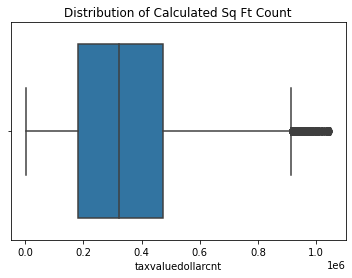

In [32]:
#visualize the same data as above
sns.boxplot(df.taxvaluedollarcnt)
plt.title('Distribution of Calculated Sq Ft Count')
plt.show()

In [ ]:
train, validate, test = wz.train_validate_test_split(df)

In [ ]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wz.zillow_split(df, 'logerror')

In [ ]:
df = train

In [ ]:
train.head()

In [ ]:
X_train.head()

In [ ]:
df.columns

In [ ]:
# identify columns to be scaled
numeric_cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror']

In [ ]:
#use min_max_scaler function from prepare.py
X_train_scaled, X_validate_scaled, X_test_scaled = wz.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [ ]:
X_train_scaled

In [ ]:
#see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

In [ ]:
# use RFE to find best features for analysis

X = X_train[list(X_train.select_dtypes(exclude=['object']).columns)]
y = y_train

#create model
lm = LinearRegression()
#select hyperparameters
rfe = RFE(estimator=lm, n_features_to_select=3)
#fit model
rfe.fit(X, y)

X.columns[rfe.support_]

In [ ]:
#make easier to read
pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

In [ ]:
#visualize Log error vs taxamount
sns.lmplot(x='taxamount', y='logerror', data=train)
plt.title('Logerror vs taxamount with mean line of logerror')
plt.show()

In [ ]:
#visualize log error vs lotsizesquarefeet
sns.lmplot(x='lotsizesquarefeet', y='logerror', data=train)
plt.title('Logerror vs lotsizesquarefeet with mean line of logerror')
plt.show()

In [ ]:
#visualize log error vs longitude
sns.lmplot(x='calculatedfinishedsquarefeet', y='logerror', data=train)
plt.title('Logerror vs calculatedfinishedsquarefeet with mean line of logerror')
plt.show()

In [ ]:
#visualize Log error vs bedroomcnt
sns.lmplot(x='bedroomcnt', y='logerror', data=train)
plt.title('Logerror vs bedroomcnt with mean line of logerror')
plt.show()

In [ ]:
#create pairplot in train dataset
cols = ['taxamount', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'logerror']

sns.pairplot(data = train[cols])
plt.show()

## Hypothesis Testing:
- correlation testing: tests two continuous variables
- pearsons looks to find if two samples have a linear relationship
- r, p = stats.pearsonsr(x,y)

- T-Test: tests a continuous and a discrete variable
- t, p = stats.ttest_ind(x,y, equal_var=)


## Hypothesis 1: Correlation Test (Taxamount vs Logerror)
- $H_0$: There is no correlation between logerror and taxamount
- $H_a$: There ia a correlation between logerror and taxamount

In [ ]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.taxamount)
print('r-value:',round(r,5),'p-value:',round(p,5))

In [ ]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and taxamount')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and taxamount')

## Hypothesis 2: Correlation Test (Logerror vs Property_Age)
- $H_0$: There is no correlation between logerror and lotsizesquarefeet
- $H_a$: There is a correlation between logerror and lotsizesquarefeet

In [ ]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.lotsizesquarefeet)
print('r-value:',round(r,5),'p-value:',round(p,5))

In [ ]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and lotsizesquarefeet')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and lotsizesquarefeet')

## Hypothesis 3: Correlation Test ( Logerror vs Calculated finished squre feet)
- $H_0$: There is no correlation between logerror and calculatedfinishedsquarefeet
- $H_a$: There is a correlation between logerror and calculatedfinishedsquarefeet


In [ ]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.calculatedfinishedsquarefeet)
print('r-value:',round(r,5),'p-value:',round(p,5))

In [ ]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and calculatedfinishedsquarefeet')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and calculatedfinishedsquarefeet')

## Hypothesis 4: T-Test (Logerror vs Bedroomcnt)
- $H_0$: There is no relationship between logerror and bedroomcnt
- $H_a$: There is a relationship between logerror and bedroomcnt

In [ ]:
#set alpha
alpha = .05

In [ ]:
# sample size, must be more then 30 to meet assumption
train.logerror.count(), train.bedroomcnt.count()

In [ ]:
#check variance
train.logerror.var(), train.bedroomcnt.var()

#this shows not equal varient

In [ ]:
#t-test on entire train set
t, p = stats.ttest_ind(train.bedroomcnt,train.logerror, equal_var=False)

print('t-value:',round(t,5),'p-value:',round(p,5))

In [ ]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and bedroomcnt')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and bedroomcnt')

### Takeaways from Hypothesis Testing:
We have failed to reject all four $H_0$.
There are relationships between these features and logerror.

*****************************************************************************

## Clustering
## Brainstorm about clusters:
- WHAT is logerror??
   - in this context, it is predicted sale price(Zestimate) being different from actual sale price

- reasons WHY logerror may exist...
   number of bedrooms
   square feet of the home
   lot size of the property


In [ ]:
#chose variables for this possible cluster
X = train[['calculatedfinishedsquarefeet', 'taxamount']]
#take a look
X.head()

In [ ]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
X_scaled.info()

In [ ]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
#use scatter_plot function from explore.py
#this will show you different clusters with varying k values
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for ax, k in zip(axs.ravel(), range(2, 6)):
        clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
        ax.scatter(X.calculatedfinishedsquarefeet, X.taxamount, c=clusters)
        ax.set(title='k = {}'.format(k), xlabel='calculatedfinishedsquarefeet', ylabel='taxamount')


In [ ]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [ ]:
sns.boxplot(train.bathroomcnt, train.logerror)
plt.title('Bathroom Count and Log Error')
plt.show()

In [ ]:
sns.boxplot(train['fips'], train['logerror'])
plt.title('Potential Difference in Logerror by FIPS')
plt.ylim(-.16, .16)
plt.show()

In [ ]:
# null hyothesis: mean_6037 == mean_6111
# alt hypothesis: mean_is_6037 != mean_6111

# Using levene to test variance
print(stats.levene(train[train.fips==6037].logerror, train[train.fips==6111].logerror))

# using two sample, two tailed ttest
print(stats.ttest_ind(train[train.fips==6037].logerror, train[train.fips==6111].logerror, equal_var=False))

In [ ]:
train.fips.value_counts()

In [ ]:
train.county.value_counts()

In [ ]:
sns.boxplot(train.county, train.logerror)
plt.title('Potential difference in logerror across counties')
plt.ylim(-.16, .16)
plt.show()

In [ ]:
stats.levene(train[train.county == 'Los Angeles'].logerror, train[train.county == 'Orange'].logerror)

In [ ]:
print('Relationship between Square footage and Logerror?')
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train)
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Logerror')
plt.show()

In [ ]:
print('Relationship between Longitude and Logerror?')
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Logerror')
plt.show()

In [ ]:
print('Relationship between Bedroom count and Logerror?')
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Logerror')
plt.show()

In [ ]:
stats.levene(train[train.bedroomcnt > 5].logerror, train[train.bedroomcnt <= 5].logerror)